In [1]:
import requests, zipfile, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
from xifa import GRM

jax.config.update("jax_enable_x64", True)

In [2]:
def download_dataset(dataset_url,
                     dataset_name):
    req = requests.get(dataset_url, allow_redirects=True)
    open(dataset_name + '.zip',"wb").write(req.content)
    zipfile.ZipFile(dataset_name + '.zip').extractall()
    os.remove(dataset_name+'.zip')

In [3]:
dataset_url = "http://openpsychometrics.org/_rawdata/BIG5.zip"
dataset_name = "big5"
download_dataset(dataset_url, dataset_name)

In [4]:
data = pd.read_csv("BIG5/data.csv", sep="\t").iloc[:,-50:]
data = data.replace(0, np.nan)
data = data.dropna()

In [5]:
data = data - 1.0
negative_items = ["E2", "E4", "E6", "E8", "E10",
                  "N2", "N4",
                  "A1", "A3", "A5", "A7",
                  "C2", "C4", "C6", "C8",
                  "O2", "O4", "O6"]
data[negative_items] = 4 - data[negative_items]

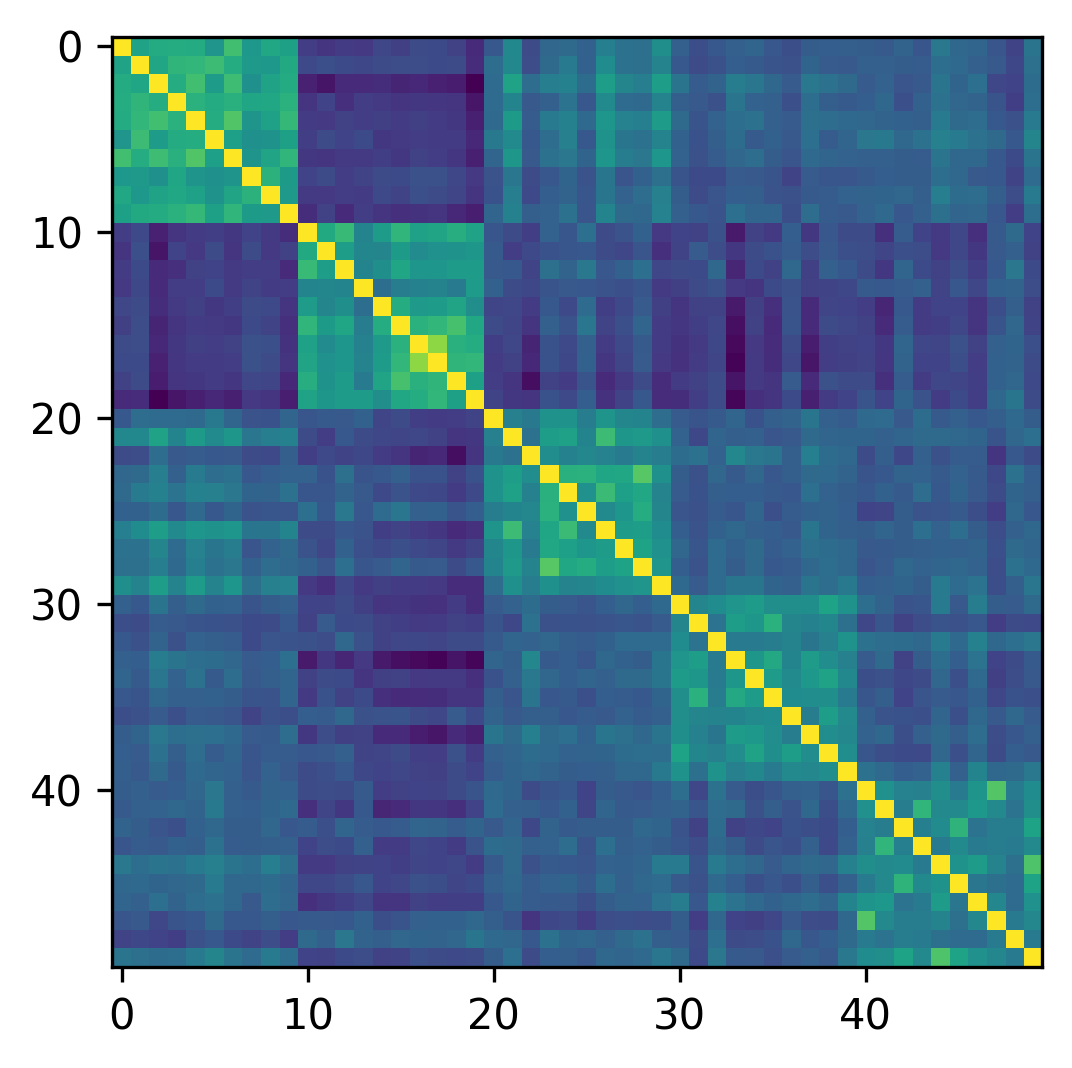

In [6]:
plt.figure(figsize=(4, 8), dpi=300)
plt.imshow(data.corr(),
           cmap='viridis')
plt.show()

In [7]:
n_factors = 5
n_items = 50
q = int(n_items / n_factors)
pattern = {"labda":{m: set(range(m * q, (m + 1) * q)) for m in range(n_factors)}}
grm = GRM(data = data,
          n_factors = 5,
          pattern = pattern)
grm.fit(lr=1.,
        max_iter=1000,
        discard_iter=200,
        tol=10 ** (-4),
        window_size=3,
        chains=1,
        warm_up=5,
        jump_scale="optimal",
        adaptive_jump=True,
        target_rate=.23,
        sa_power=1.,
        cor_update="gd",
        verbose=True,
        key=None,
        batch_size=None,
        params=None,
        masks=None)

A GRM Object is Initialized Successfully.
 + Number of Cases: 19718
 + Number of Items: 50
 + Number of Factors: 5
 + Number of Categories: 5
Converged after 283 Iterations (205.97 sec).


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

In [8]:
np.round(grm.params["labda"], 2)

DeviceArray([[1.75, 0.  , 0.  , 0.  , 0.  ],
             [1.87, 0.  , 0.  , 0.  , 0.  ],
             [2.11, 0.  , 0.  , 0.  , 0.  ],
             [2.09, 0.  , 0.  , 0.  , 0.  ],
             [2.57, 0.  , 0.  , 0.  , 0.  ],
             [1.6 , 0.  , 0.  , 0.  , 0.  ],
             [2.47, 0.  , 0.  , 0.  , 0.  ],
             [1.25, 0.  , 0.  , 0.  , 0.  ],
             [1.48, 0.  , 0.  , 0.  , 0.  ],
             [1.96, 0.  , 0.  , 0.  , 0.  ],
             [0.  , 1.86, 0.  , 0.  , 0.  ],
             [0.  , 1.19, 0.  , 0.  , 0.  ],
             [0.  , 1.47, 0.  , 0.  , 0.  ],
             [0.  , 0.83, 0.  , 0.  , 0.  ],
             [0.  , 1.34, 0.  , 0.  , 0.  ],
             [0.  , 2.36, 0.  , 0.  , 0.  ],
             [0.  , 2.23, 0.  , 0.  , 0.  ],
             [0.  , 2.56, 0.  , 0.  , 0.  ],
             [0.  , 2.08, 0.  , 0.  , 0.  ],
             [0.  , 1.8 , 0.  , 0.  , 0.  ],
             [0.  , 0.  , 1.07, 0.  , 0.  ],
             [0.  , 0.  , 1.6 , 0.  , 0.  ],
          

In [9]:
np.round(grm.params["phi"], 2)

DeviceArray([[ 1.  , -0.29,  0.42,  0.15,  0.23],
             [-0.29,  1.  , -0.1 , -0.33, -0.14],
             [ 0.42, -0.1 ,  1.  ,  0.21,  0.18],
             [ 0.15, -0.33,  0.21,  1.  ,  0.12],
             [ 0.23, -0.14,  0.18,  0.12,  1.  ]], dtype=float64)